Выборка содержит 10 признаков, однако для удобства визуализации мы воспользуемся только двумя из них. Попробуем взять признаки "цена" и "объем" и сравним результаты кластеризации с этими признаками и признаками, полученными понижением размерности методом главных компонент.

In [68]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

my_cmap = ListedColormap(sns.color_palette("bright").as_hex())


data_orig = pd.read_csv('dataset.csv', index_col=0)

data = data_orig.drop('bitcoin_pumped', axis=1)

data = np.array(data.iloc[:])

s = StandardScaler()

data = s.fit_transform(data) # scaling features is very important for k-means
pca = PCA(n_components=2) # extracting most important features with PCA algorithm
x2_data = pca.fit_transform(data)

data = data[:, 8:10] # extracting Price and Volume features manually
plot_x = data[:, 0]
plot_y = data[:, 1]

plot_x2 = x2_data[:, 0]
plot_y2 = x2_data[:, 1]

kmeans_1 = KMeans(n_clusters=3, n_init=20).fit(data)
clusters = kmeans_1.predict(data)

kmeans_2 = KMeans(n_clusters=3, n_init=20).fit(x2_data)
clusters2 = kmeans_2.predict(x2_data)

0.818791946309


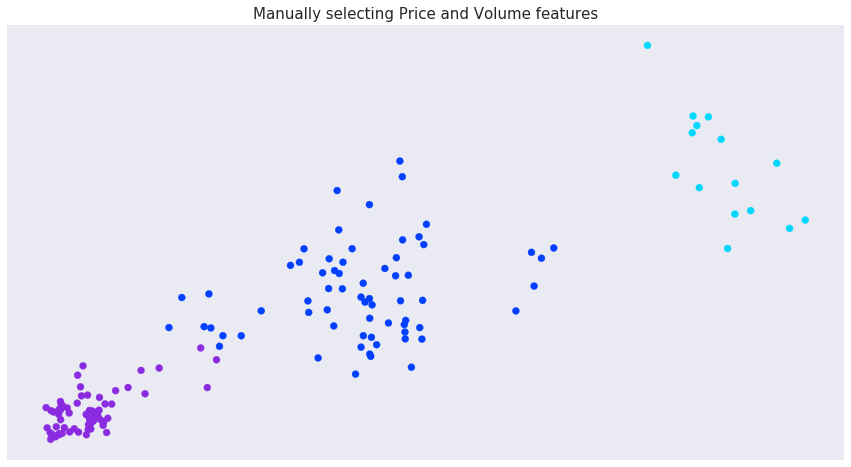

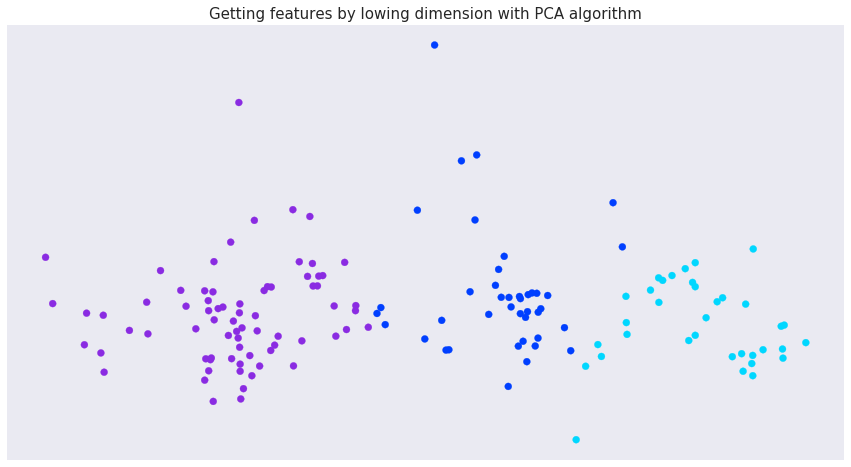

In [42]:
one_mask = np.where(clusters == 2) # replacing clusters to get the same colors as in the case with PCA
clusters[clusters == 0] = 2
clusters[one_mask] = 0

plt.figure(figsize=(15, 8))
plt.scatter(plot_x, plot_y, c=clusters, cmap=my_cmap)
plt.title('Manually selecting Price and Volume features', size=15)
plt.yticks(())
plt.xticks(())

plt.figure(figsize=(15, 8))
plt.scatter(plot_x2, plot_y2, c=clusters2, cmap=my_cmap)
plt.title('Getting features by lowing dimension with PCA algorithm', size=15)
plt.yticks(())
plt.xticks(())

print (accuracy_score(clusters, clusters2))

plt.show()

Мы попробовали запустить алгоритм с различным параметром K - от 2 до 5, однако визуально мы можем четко отличить 3 скопления точек как при ручном выборе признаков, так и при подборе их методом главных компонент. Возьмем кластеризацию при параметре K=3 за основу для дальнейшего анализа.

Как можно заметить, результаты, полученные с помощью понижения размерности методом главных компонент практически идентичны тем, что мы получили, вручную взяв признаки "цена" и "объем" (cходство больше 80%). Таким образом, можно сказать, что они действительно являются наиболее "весомыми" из признаков. 

Теперь попробуем разобраться, что именно представляют собой образовавшиеся кластеры. Взглянув на данные, можно предположить, что кластерами являются интервалы цен, в которых находился курс биткоина на протяжении продолжительного времени. Проверим так ли это: построим гистограмму распределения цен, отметив на ней наши кластеры, а также визуализируем рост курса биткоина, чтобы более четко разглядеть эти самые интервалы.

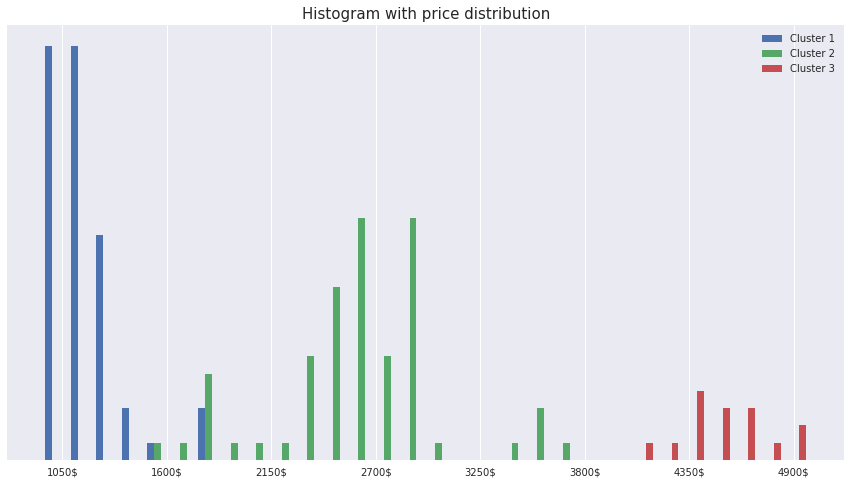

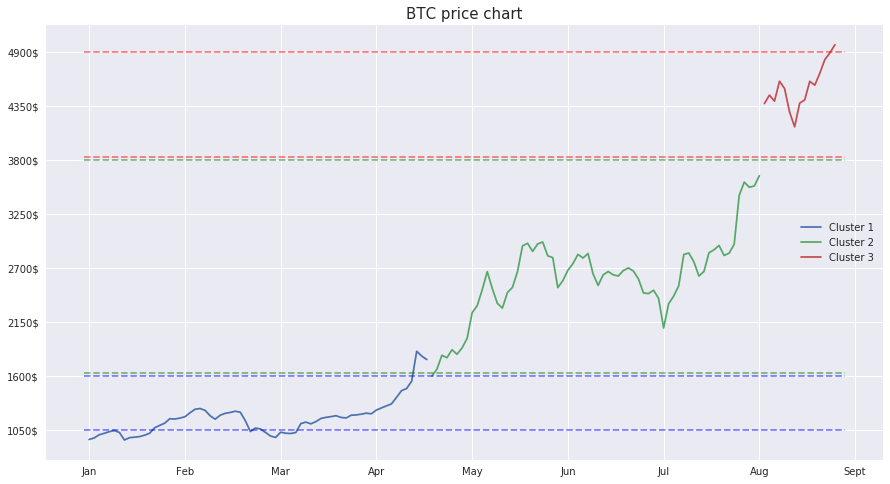

In [52]:
first = np.where(clusters == 1)
sec = np.where(clusters == 0)
third = np.where(clusters == 2)

labels = ['Cluster 1', 'Cluster 2', 'Cluster 3']

plt.figure(figsize=(15, 8))
plt.hist([data[first][:, 0], data[sec][:, 0], data[third][:, 0]], bins=30, label=labels)
plt.yticks(())
plt.legend()
plt.xticks([-1 + i*0.5 for i in range(8)], [str(500 + i*550)+'$' for i in range(1, 9)])
plt.title('Histogram with price distribution', size=15)

first_end = len(data[first])
sec_end = first_end + len(data[sec])


plt.figure(figsize=(15, 8))
#plt.scatter(np.arange(len(data)), data[:, 0], c=clusters2, cmap=my_cmap)
plt.plot(np.arange(first_end), data[first][:, 0], label=labels[0])
plt.plot(np.arange(first_end, sec_end), data[sec][:, 0], label=labels[1])
plt.plot(np.arange(sec_end, sec_end + len(data[third])), data[third][:, 0], label=labels[2])
plt.legend()
plt.title('BTC price chart', size=15)
plt.plot([-1, 150], [-1, -1], alpha=0.5, c='blue', linestyle='--')
plt.plot([-1, 150], [-0.5, -0.5], alpha=0.5, c='blue', linestyle='--')
plt.plot([-1, 150], [-0.47, -0.47], alpha=0.5, c='green', linestyle='--')
plt.plot([-1, 150], [1.5, 1.5], alpha=0.5, c='green', linestyle='--')
plt.plot([-1, 150], [1.53, 1.53], alpha=0.5, c='red', linestyle='--')
plt.plot([-1, 150], [2.5, 2.5], alpha=0.5, c='red', linestyle='--')


plt.yticks([-1 + i*0.5 for i in range(8)], [str(500 + i*550)+'$' for i in range(1, 9)])
plt.xticks([i * 19 for i in range(9)], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept'])

plt.show()

Как на гистрограмме, так и на линейной диаграмме отчетливо видны 3 интервала цен с центрами в 1100, 2600 и 4350. Таким образом, мы подтвердили нашу теорию о природе найденных алгоритмом кластеров.

Теперь сравним центры наших кластеров с общим средним. Как видно на графике, общее среднее находится между центрами первого и второго кластеров, вдалеке от центра третьего кластера, что неудивительно, так как в этот кластер вошло меньше всего объектов нашей выборки.

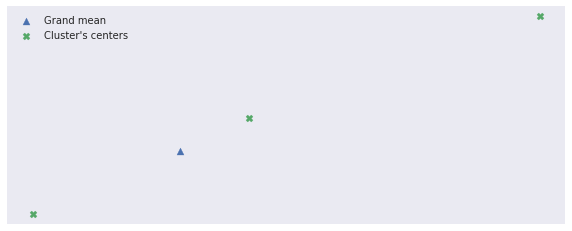

In [63]:
grand_mean = np.mean(data, axis=0)
cluster_centers = kmeans_1.cluster_centers_
#print (cluster_centers)

#print (len(first[0]), len(sec[0]), len(third[0]))
plt.figure(figsize=(10, 4))

plt.scatter(grand_mean[0], grand_mean[1], marker='^', label='Grand mean')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', label="Cluster's centers")
plt.grid(True)
plt.legend()

plt.yticks(())
plt.xticks(())

plt.show()

Далее возьмем один из признаков и с помощью бутстраппинга провалидируем его средние значения внутри каждого из кластеров: определим распределение данных используя Смесь Гауссовых Распределений (GMM - Gaussian Mixture Model), а затем на основе полученной информации сгенерируем новых выборок и построим распределение для средних значений кластеров.

In [54]:
from sklearn.mixture import GaussianMixture

prices_first = data[first][:, 0][:, np.newaxis]
prices_sec = data[sec][:, 0][:, np.newaxis]
prices_third = data[third][:, 0][:, np.newaxis]


#print (prices_first)

gmm = GaussianMixture(n_components=8, covariance_type='full')
gmm.fit(prices_first)

gmm2 = GaussianMixture(n_components=8, covariance_type='full')
gmm2.fit(prices_sec)

gmm3 = GaussianMixture(n_components=4, covariance_type='full')
gmm3.fit(prices_third)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [55]:
means_f = [np.mean(gmm.sample(len(prices_first))[0], axis=0)[0] for i in range(10000)]
means_s = [np.mean(gmm2.sample(len(prices_sec))[0], axis=0)[0] for i in range(10000)]
means_t = [np.mean(gmm3.sample(len(prices_third))[0], axis=0)[0] for i in range(10000)]

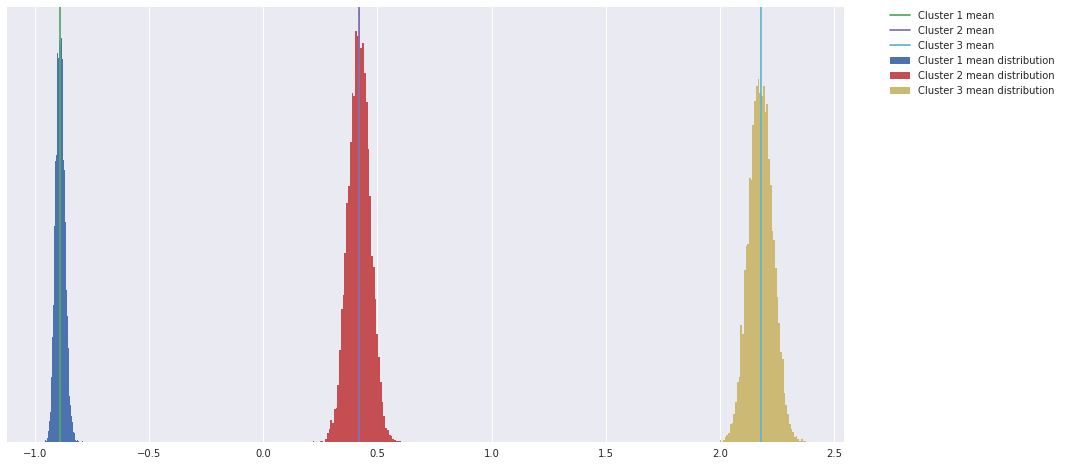

In [64]:
plt.figure(figsize=(15, 8))

plt.hist(means_f, bins=50, label='Cluster 1 mean distribution')
plt.plot([cluster_centers[1][0], cluster_centers[1][0]], [0, 720], label='Cluster 1 mean')

plt.hist(means_s, bins=50, label='Cluster 2 mean distribution')
plt.plot([cluster_centers[2][0], cluster_centers[2][0]], [0, 720], label='Cluster 2 mean')

plt.hist(means_t, bins=50, label='Cluster 3 mean distribution')
plt.plot([cluster_centers[0][0], cluster_centers[0][0]], [0, 720], label='Cluster 3 mean')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(ymin=0, ymax=680)
plt.yticks(())
plt.show()


Как можно заметить, распределения, найденные для второго и третьего кластеров, более "плавные", что говорит о том, что объекты, вошедшие в эти кластера, имеют больший разброс. Сравним общие средние для первого и третьего кластеров, используя бутстрап: для каждой сгенерированной выборки (T1 -выборка 1го кластера, T2 - выборка 3го кластера, а всего их 10000 для каждого кластера) посчитаем D = mean(T1) - mean(T2), и построим 95% доверительный интервал для D.

In [74]:
import numpy as np, scipy.stats as st


t1, t2 = np.array(means_f), np.array(means_t)
res = t1 - t2

print (st.norm.interval(0.95, loc=np.mean(res), scale=st.sem(res)))

(-3.0673782043541737, -3.0651750185605322)


Так как 0 не входит в полученный интервал, это означает, что одно среднее больше другого, что, впрочем, итак очевидно для нашей выборки.

In [150]:
#HW 5
from sklearn.preprocessing import MinMaxScaler, StandardScaler
features = np.zeros((7, 149))
# selected features = Low GSPC, Volume GSPC, Low DJI, Volume DJI, EUR/USD Low
features_before_scale = data_orig.iloc[:, [1, 2, 4, 5, 7]].as_matrix()

range_scaler = MinMaxScaler()
std_scaler = StandardScaler()

range_scaled_data = range_scaler.fit_transform(features_before_scale)

std_scaled_data = std_scaler.fit_transform(features_before_scale)

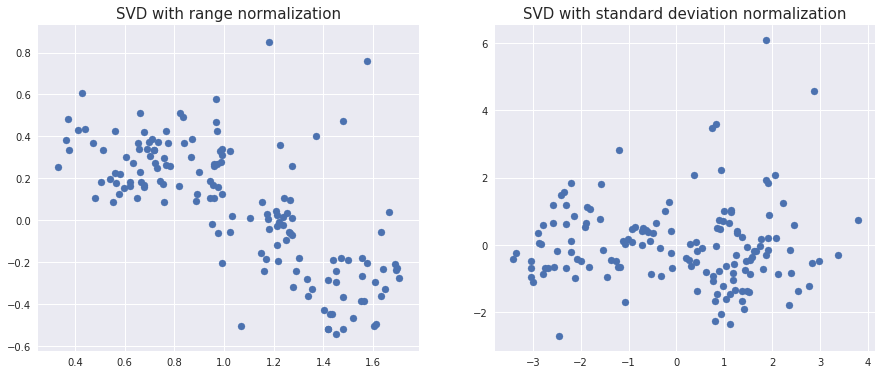

In [174]:
from sklearn.decomposition import TruncatedSVD, PCA

svd = TruncatedSVD()

ranged_ = svd.fit_transform(range_scaled_data)
std_ = svd.fit_transform(std_scaled_data)

plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.title('SVD with range normalization', size=15)
plt.scatter(ranged_[:, 0], ranged_[:, 1])

plt.subplot(1,2,2)
plt.title('SVD with standard deviation normalization', size=15)
plt.scatter(std_[:, 0], std_[:, 1])

plt.show()

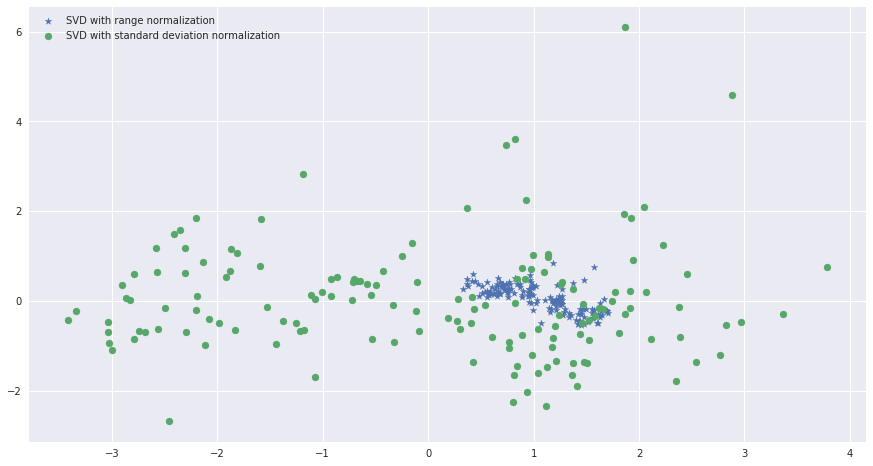

In [178]:
plt.figure(figsize=(15, 8))

plt.scatter(ranged_[:, 0], ranged_[:, 1], label='SVD with range normalization', marker='*')

plt.scatter(std_[:, 0], std_[:, 1], label='SVD with standard deviation normalization')
plt.legend()
plt.show()

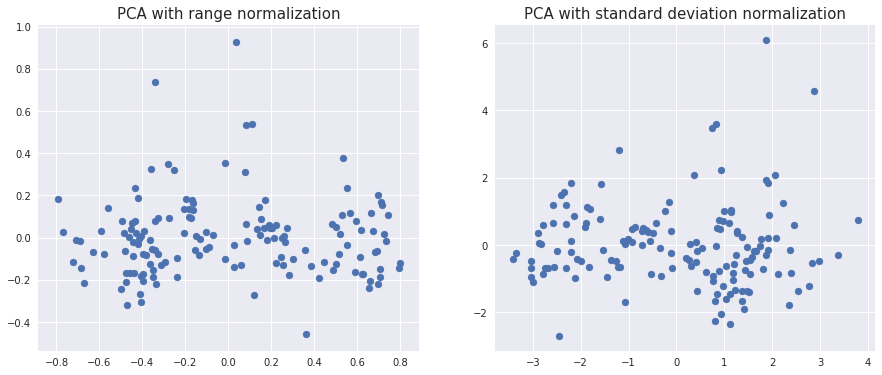

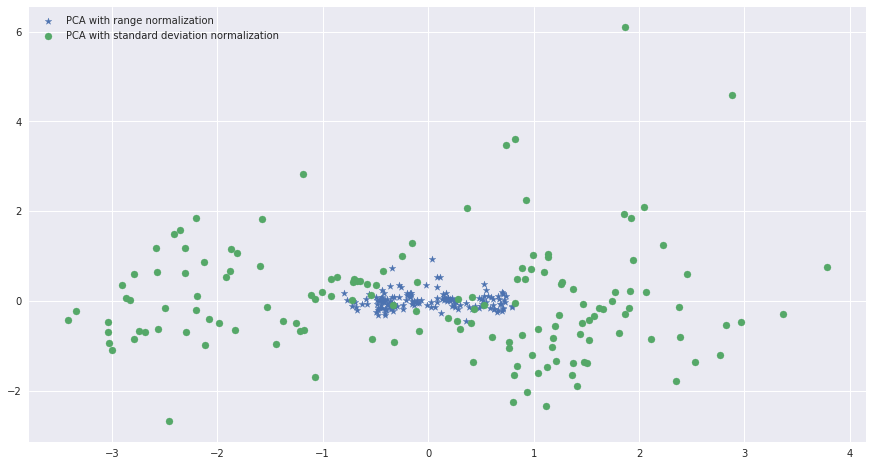

In [179]:
pca = PCA()

ranged_pca = pca.fit_transform(range_scaled_data)
std_pca = pca.fit_transform(std_scaled_data)

plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.title('PCA with range normalization', size=15)
plt.scatter(ranged_pca[:, 0], ranged_pca[:, 1])

plt.subplot(1,2,2)
plt.title('PCA with standard deviation normalization', size=15)
plt.scatter(std_pca[:, 0], std_pca[:, 1])

plt.figure(figsize=(15, 8))

plt.scatter(ranged_pca[:, 0], ranged_pca[:, 1], label='PCA with range normalization', marker='*')

plt.scatter(std_pca[:, 0], std_pca[:, 1], label='PCA with standard deviation normalization')
plt.legend()
plt.show()

plt.show()

In [71]:
# calculating number of objects with categorial features for building contingency table later

contingency_table_price = { 0 : { -1 : 0, 1 : 0 }, 1 : { -1 : 0, 1 : 0 }, 2 : { -1 : 0, 1 : 0 } }
contingency_table_volume = { 0 : { -1 : 0, 1 : 0 }, 1 : { -1 : 0, 1 : 0 }, 2 : { -1 : 0, 1 : 0 } }

for idx, cluster in enumerate(clusters):
    contingency_table_price[cluster][data_orig['bitcoin_price_more_avg'].iloc[idx]] += 1
    contingency_table_volume[cluster][data_orig['bitcoin_volume_more_avg'].iloc[idx]] += 1
    
print ('Bitcoin_price_more_avg', contingency_table_price)
print ('Bitcoin_volume_more_avg', contingency_table_volume)

Bitcoin_price_more_avg {0: {1: 0, -1: 68}, 1: {1: 16, -1: 0}, 2: {1: 56, -1: 9}}
Bitcoin_volume_more_avg {0: {1: 0, -1: 68}, 1: {1: 16, -1: 0}, 2: {1: 51, -1: 14}}


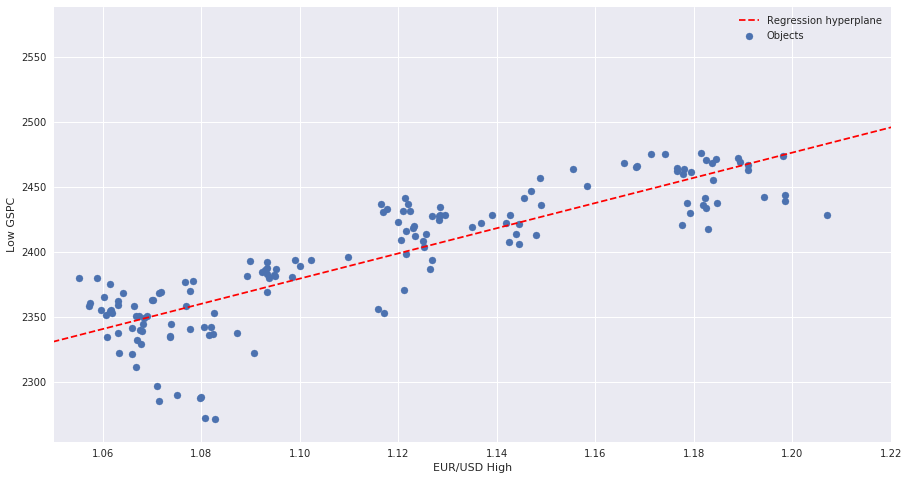

In [95]:
# HW 6, linear regression

from sklearn.linear_model import LinearRegression

matrix_data = data_orig.as_matrix()

y_feature = matrix_data[:, 1]
x_feature = matrix_data[:, 6]

clf = LinearRegression()
clf.fit(x_feature[:, np.newaxis], y_feature)

plt.figure(figsize=(15, 8))

# visualize regression separating hyperplane
x_plot = np.linspace(1, 1.3, num=100)
plt.plot(x_plot, clf.predict(x_plot[:, np.newaxis]), linestyle='--', color='red', label='Regression hyperplane')
plt.xlim(xmin=1.05, xmax=1.22)
plt.scatter(x_feature, y_feature, label='Objects')
plt.legend()
plt.xlabel('EUR/USD High')
plt.ylabel('Low GSPC')

plt.show()

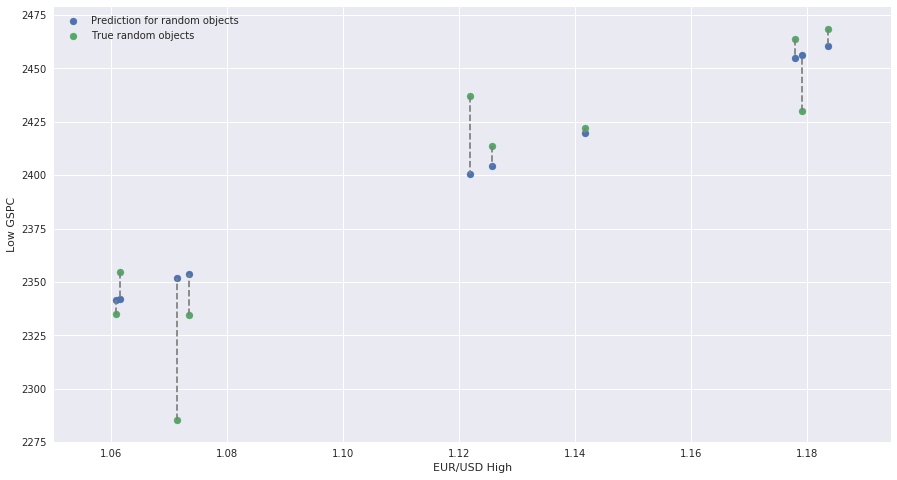

In [115]:
plt.figure(figsize=(15, 8))

indexes = np.random.randint(0, len(x_feature), size=10)

rand_x = x_feature[indexes]
true_y = y_feature[indexes]

rand_y = clf.predict(rand_x[:, np.newaxis])

plt.scatter(rand_x, rand_y, label='Prediction for random objects')
plt.scatter(rand_x, true_y, label='True random objects')
for i in range(10):
    plt.plot([rand_x[i], rand_x[i]], [true_y[i], rand_y[i]], linestyle='--', color='grey')
plt.legend()
plt.xlabel('EUR/USD High')
plt.ylabel('Low GSPC')
plt.show()

In [129]:
# calculating relative absolute error
print ('Relative absolute error - {}'.format(np.sum(np.absolute(true_y - rand_y)) / np.sum(np.absolute(true_y - np.mean(true_y)))))

Relative absolute error - 0.3643823612385651
